In [4]:
library(rstan)
library(here)
library(bayesplot)
library(ggfortify)
library(gridExtra)
library(tidyverse)
# 計算の高速化
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())

source(here("plotSSM.r"), encoding = "utf-8")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [15]:
fish_ts <- read.csv(here("data", "5-9-1-fish-num-ts.csv"))
fish_ts$date <- as.POSIXct(fish_ts$date)
head(fish_ts, n = 3)


,date,fish_num,temperature
,<dttm>,<int>,<dbl>
1,2010-01-01,2,1.8
2,2010-01-02,1,7.0
3,2010-01-03,2,5.7


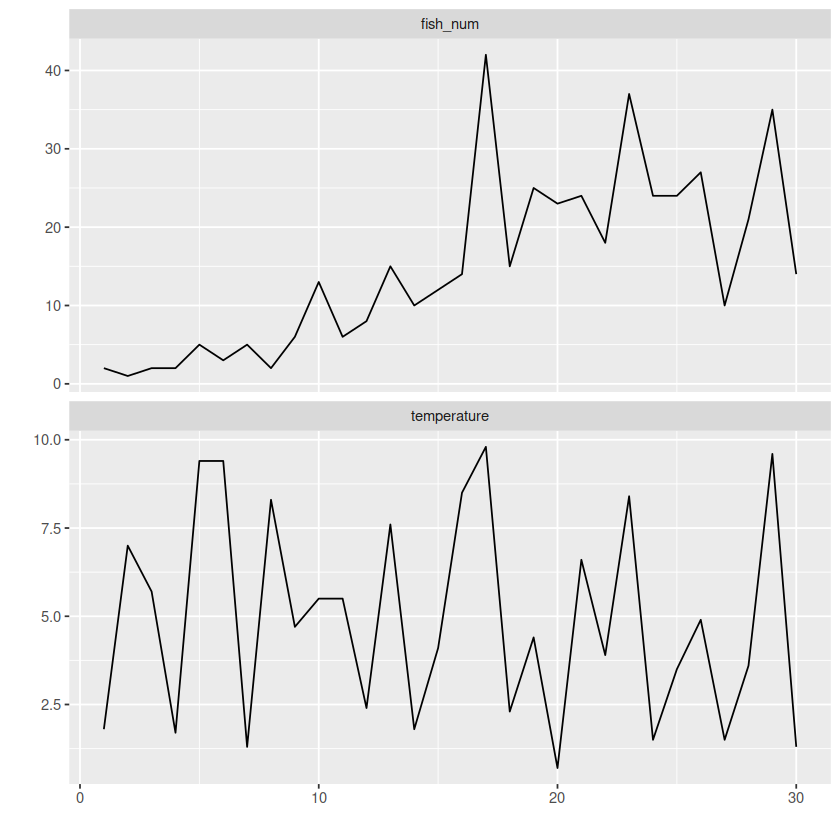

In [16]:
autoplot(ts(fist_ts[, -1]))


In [17]:
dglm_poisson <- list(
  y = fish_ts$fish_num,
  ex = fish_ts$temperature,
  T = nrow(fish_ts)
) %>%
  stan(
    file = here("5部", "5-9-1-dgml-poisson.stan"),
    data = .,
    seed = 1,
    iter = 2000,
    thin = 6,
    control = list(adapt_delta = 0.99, max_treedepth = 15)
  )


Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”



Divergences:


0 of 668 iterations ended with a divergence.




Tree depth:


0 of 668 iterations saturated the maximum tree depth of 15.




Energy:


E-BFMI indicated no pathological behavior.



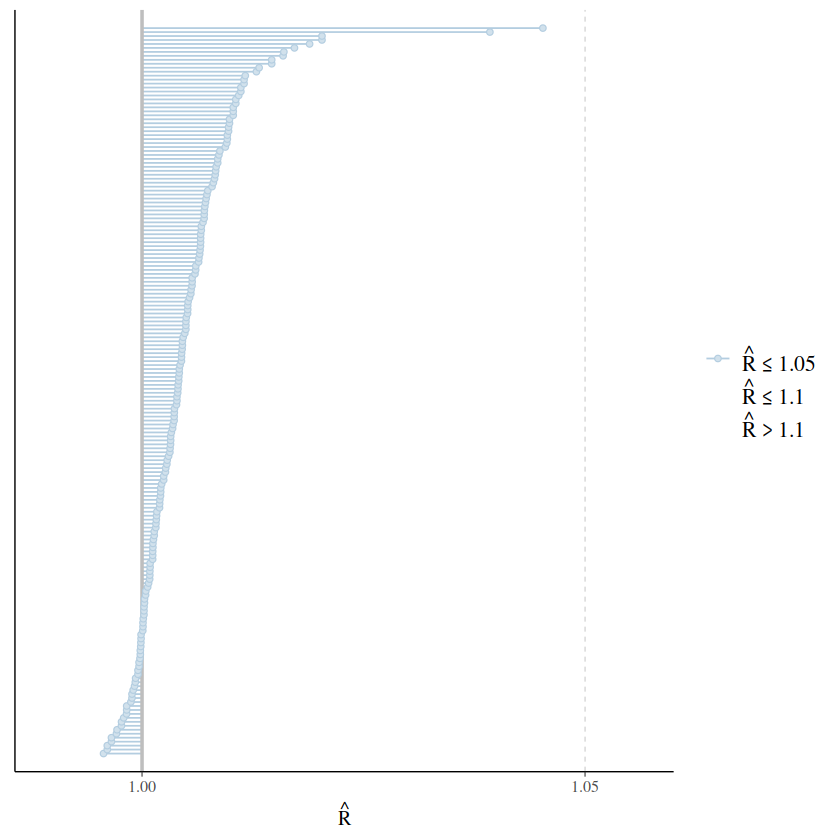

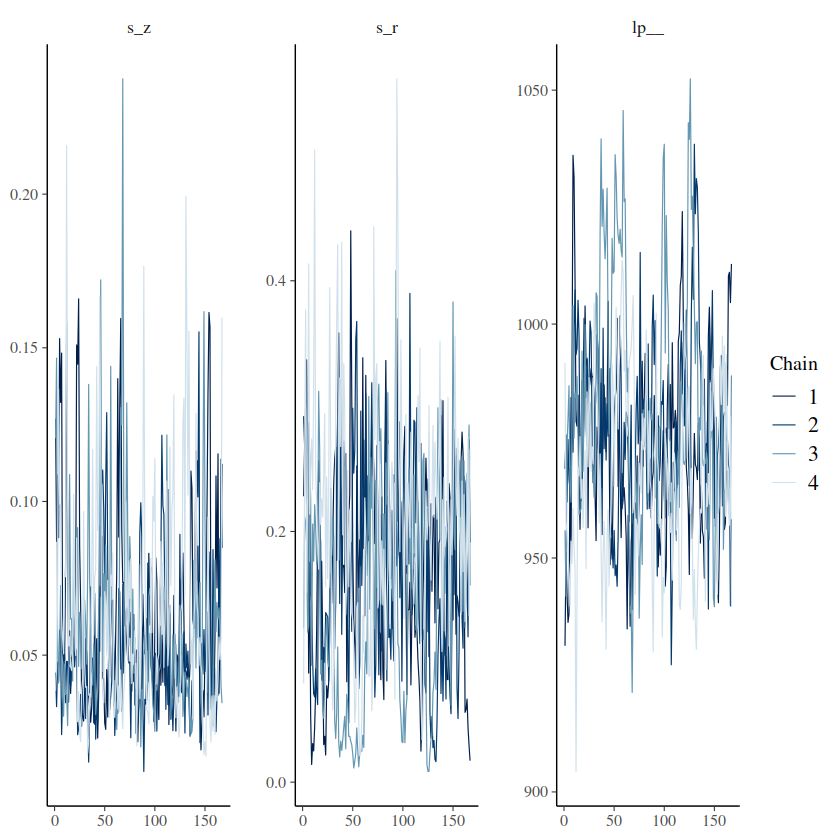

In [18]:
mcmc_rhat(rhat(dglm_poisson))
check_hmc_diagnostics(dglm_poisson)

mcmc_sample <- rstan::extract(dglm_poisson, permuted = FALSE)
mcmc_trace(mcmc_sample, pars = c("s_z", "s_r", "lp__"))


In [19]:
print(
  dglm_poisson,
  pars = c("s_z", "s_r", "lp__"),
  probs = c(0.025, 0.5, 0.975)
)


Inference for Stan model: anon_model.
4 chains, each with iter=2000; warmup=1000; thin=6; 
post-warmup draws per chain=167, total post-warmup draws=668.

       mean se_mean    sd   2.5%    50%   97.5% n_eff Rhat
s_z    0.06    0.00  0.03   0.02   0.05    0.15   219 1.02
s_r    0.18    0.01  0.09   0.02   0.18    0.36    86 1.05
lp__ 975.83    2.33 21.68 938.75 974.05 1026.94    87 1.04

Samples were drawn using NUTS(diag_e) at Wed Sep 18 17:44:49 2024.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


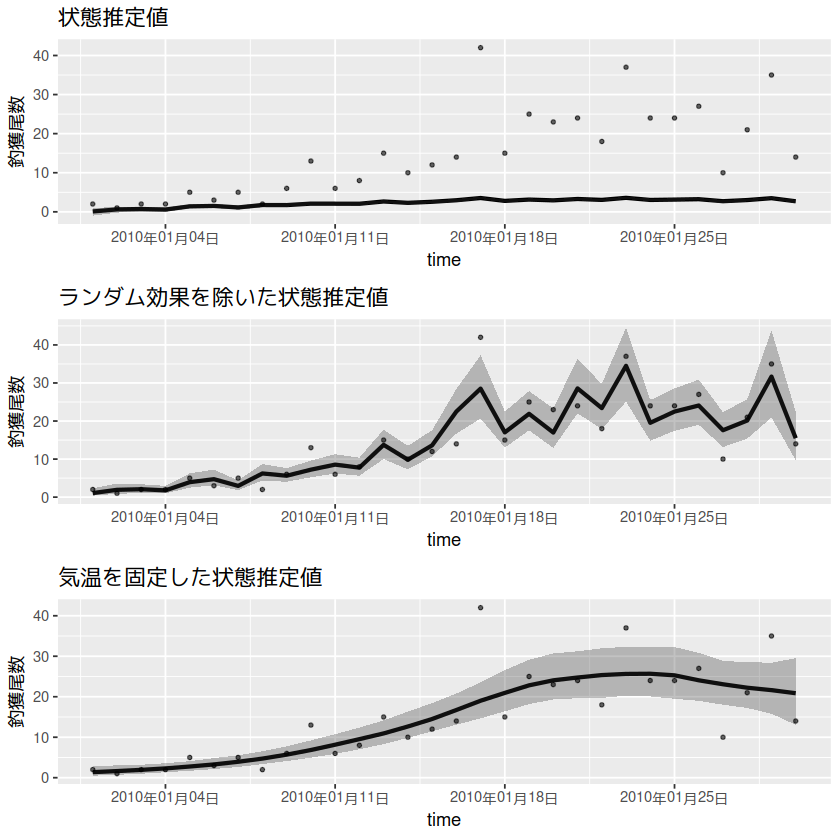

In [20]:
mcmc_sample <- rstan::extract(dglm_poisson)


p_all <- plotSSM(
  mcmc_sample = mcmc_sample,
  time_vec = fish_ts$date,
  obs_vec = fish_ts$fish_num,
  state_name = "lambda_exp",
  graph_title = "状態推定値",
  y_label = "釣獲尾数",
  date_labels = "%Y年%m月%d日"
)

p_smooth <- plotSSM(
  mcmc_sample = mcmc_sample,
  time_vec = fish_ts$date,
  obs_vec = fish_ts$fish_num,
  state_name = "lambda_smooth",
  graph_title = "ランダム効果を除いた状態推定値",
  y_label = "釣獲尾数",
  date_labels = "%Y年%m月%d日"
)

p_fix <- plotSSM(
  mcmc_sample = mcmc_sample,
  time_vec = fish_ts$date,
  obs_vec = fish_ts$fish_num,
  state_name = "lambda_smooth_fix",
  graph_title = "気温を固定した状態推定値",
  y_label = "釣獲尾数",
  date_labels = "%Y年%m月%d日"
)

grid.arrange(p_all, p_smooth, p_fix)
